### About this result

Test the pretrained model (trained with 8 particles per event) with different number of particles.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import g_main

sns.set_theme()

In [10]:
# Range of different number of particles.
diff_ptcs_range = [(2, 4), (8, 10), (14, 16)]

# The csv files that stored the prediction information.
pred_dir = f"{g_main.json_config['predictions_dir']}/ideal_model"
num_bin_data = 500 # Number of data in a bin.
num_rnd_seed = 1 # Number of random seeds that has been predicted.
csv_best = f"{pred_dir}/best_classical-{num_bin_data}_{num_rnd_seed - 1}.csv"
csv_classical = f"{pred_dir}/classical-{num_bin_data}_{num_rnd_seed - 1}.csv"
csv_quantum = f"{pred_dir}/quantum-{num_bin_data}_{num_rnd_seed - 1}.csv"

# Create pandas dataframes.
df_best = pd.read_csv(csv_best)
df_classical = pd.read_csv(csv_classical)
df_quantum = pd.read_csv(csv_quantum)
df = pd.concat((df_best, df_classical, df_quantum))

# Fill NaN or None with value 0.
df = df.fillna(0)

# Retain columns we need.
retain_info = [
    "model_name", "abbrev", "data_mode", "num_ptcs_range", "test_acc_epoch",
    "rnd_seed", "gnn_out", "gnn_hidden", "gnn_layers",
    "gnn_nn_qubits", "gnn_reupload"
]
df = df[retain_info]

# Create new columns for seaborn `hue`.
df.loc[df["model_name"] == "ClassicalMPGNN", "M"] = "C"  # Classical.
df.loc[df["gnn_out"].astype(int) == 1024, "M"] = "B"     # Best classical.
df.loc[df["model_name"] == "QuantumRotQCGNN", "M"] = "Q" # Quantum.

# Key "data_mode" in df cooresponds to training or testing data.
df["hue"] = df["M"] + "_" + df["data_mode"]
print(f"Hue for seaborn: {df['hue'].unique()}")
df

Hue for seaborn: ['B_train' 'B_test' 'C_train' 'C_test' 'Q_train' 'Q_test']


,model_name,abbrev,data_mode,num_ptcs_range,test_acc_epoch,rnd_seed,gnn_out,gnn_hidden,gnn_layers,gnn_nn_qubits,gnn_reupload,M,hue
0,ClassicalMPGNN,BB-QCD,train,"(2, 4)",0.778507,0,1024.0,1024.0,4,0.0,0.0,B,B_train
1,ClassicalMPGNN,BB-QCD,test,"(2, 4)",0.792996,0,1024.0,1024.0,4,0.0,0.0,B,B_test
2,ClassicalMPGNN,TT-QCD,train,"(2, 4)",0.760484,0,1024.0,1024.0,4,0.0,0.0,B,B_train
3,ClassicalMPGNN,TT-QCD,test,"(2, 4)",0.774756,0,1024.0,1024.0,4,0.0,0.0,B,B_test
4,ClassicalMPGNN,BB-QCD,train,"(8, 10)",0.819025,0,1024.0,1024.0,4,0.0,0.0,B,B_train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,QuantumRotQCGNN,TT-QCD,test,"(14, 16)",0.926910,0,0.0,0.0,1,3.0,3.0,Q,Q_test
32,QuantumRotQCGNN,TT-QCD,train,"(14, 16)",0.883721,0,0.0,0.0,1,5.0,5.0,Q,Q_train
33,QuantumRotQCGNN,TT-QCD,test,"(14, 16)",0.936877,0,0.0,0.0,1,5.0,5.0,Q,Q_test
34,QuantumRotQCGNN,TT-QCD,train,"(14, 16)",0.860465,0,0.0,0.0,1,7.0,7.0,Q,Q_train


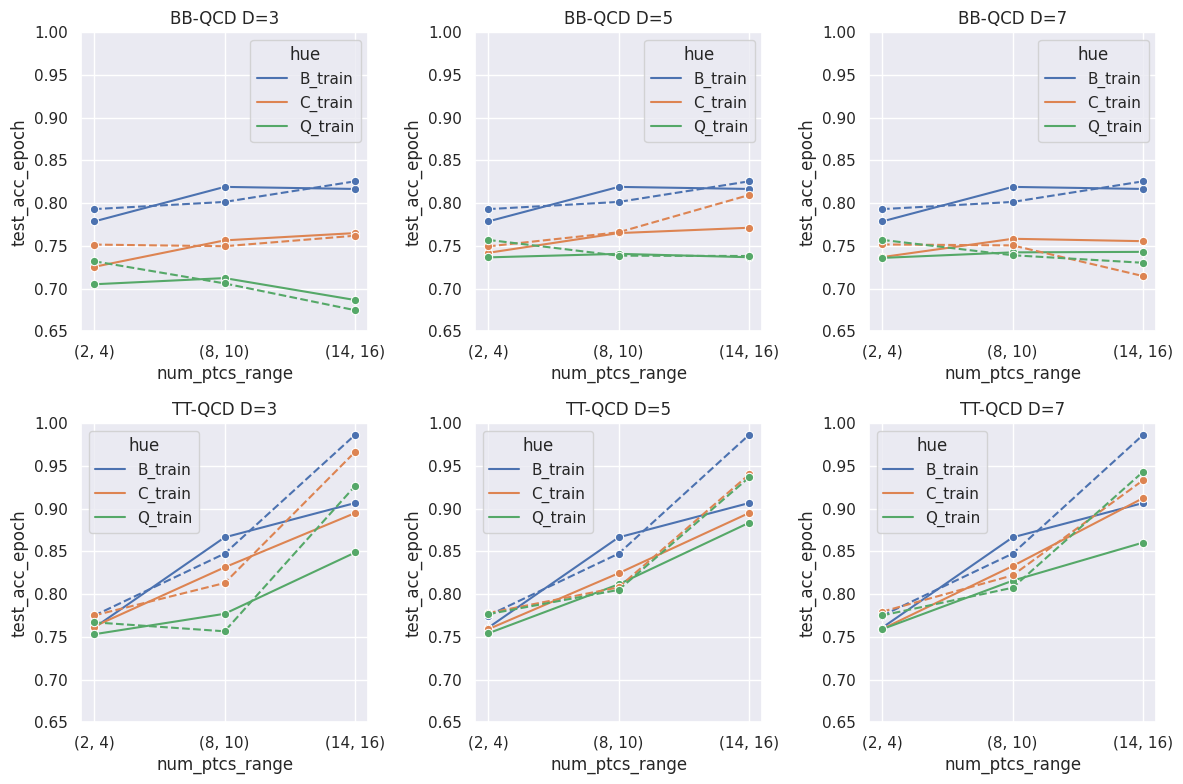

In [18]:
# Figure setup.
abbrev_list = ["BB-QCD", "TT-QCD"]
dim_list = [3, 5, 7]
num_row = len(abbrev_list)
num_col = len(dim_list)
width, height = 4 * num_col, 4 * num_row
fig, ax = plt.subplots(num_row, num_col, figsize=(width, height))

for i, abbrev in enumerate(abbrev_list):
    for j, dim in enumerate(dim_list):
        ax[i][j].set_title(f"{abbrev} D={dim}")

        # Indices with corresponding dimension.
        is_dim = (
            # Best classical and classical with dimension `dim`.
            (df["M"] ==  "B") | (df["gnn_out"].astype(int) == dim) | \
            # Quantum with dimension `dim`.
            (df["gnn_nn_qubits"].astype(int) == dim)
        )

        is_train = is_dim & (df["data_mode"] == "train")
        is_test = is_dim & (df["data_mode"] == "test")

        # Indices with corresponding abbrev (channels of jet discrimination).
        is_abbrev = (df["abbrev"] == abbrev)

        # Set y-axis limits.
        ax[i][j].set_ylim(0.65, 1.0)

        # Line plot for training data.
        sns.lineplot(
            data=df[is_train & is_abbrev], ax=ax[i][j],
            x="num_ptcs_range", y="test_acc_epoch", hue="hue",
            errorbar="se", marker="o"
        )
        
        # Line plot for testing data.
        sns.lineplot(
            data=df[is_test & is_abbrev], ax=ax[i][j],
            x="num_ptcs_range", y="test_acc_epoch", hue="hue",
            errorbar="se", marker="o", linestyle="--", legend=False
        )

plt.tight_layout()